c100.fits opened: EXPTIME=0, OBJECT=Bias, AIRMASS=1
c101.fits opened: EXPTIME=0, OBJECT=Bias, AIRMASS=1
c102.fits opened: EXPTIME=0, OBJECT=Bias, AIRMASS=1
c103.fits opened: EXPTIME=0, OBJECT=Bias, AIRMASS=1
c104.fits opened: EXPTIME=0, OBJECT=Bias, AIRMASS=1
c105.fits opened: EXPTIME=0, OBJECT=Bias, AIRMASS=1
c106.fits opened: EXPTIME=0, OBJECT=Bias, AIRMASS=1
c107.fits opened: EXPTIME=0, OBJECT=Bias, AIRMASS=1
c108.fits opened: EXPTIME=0, OBJECT=Bias, AIRMASS=1
c109.fits opened: EXPTIME=0, OBJECT=Bias, AIRMASS=1
c113.fits opened: EXPTIME=5, OBJECT=Arclamps, AIRMASS=1
c114.fits opened: EXPTIME=5, OBJECT=Arclamps, AIRMASS=1
c115.fits opened: EXPTIME=5, OBJECT=Arclamps, AIRMASS=1
c116.fits opened: EXPTIME=5, OBJECT=Arclamps, AIRMASS=1
c117.fits opened: EXPTIME=5, OBJECT=Arclamps, AIRMASS=1
c118.fits opened: EXPTIME=15, OBJECT=Domeflats, AIRMASS=1
c119.fits opened: EXPTIME=15, OBJECT=Domeflats, AIRMASS=1
c120.fits opened: EXPTIME=15, OBJECT=Domeflats, AIRMASS=1
c121.fits opened: EXPTIME=

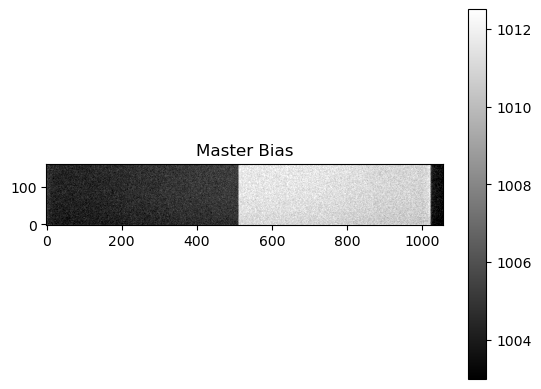

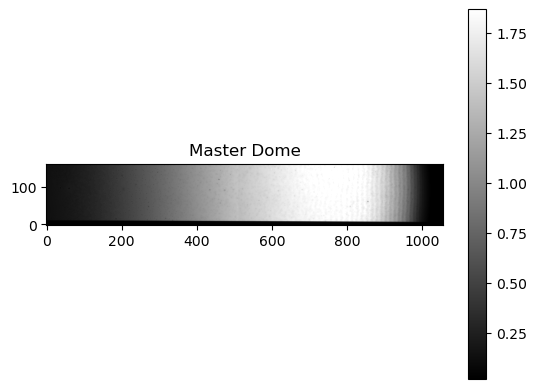

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

bias = []
dome = []

for i in range(200):
    try:
        hdul = fits.open(f'c{i}.fits')
        print(f'c{i}.fits opened: EXPTIME={hdul[0].header.get("EXPTIME")}, OBJECT={hdul[0].header.get("OBJECT")}, 
    AIRMASS={hdul[0].header.get("AIRMASS")})
        
        if hdul[0].header['EXPTIME'] == 0:
            biass = hdul[0].data
            for j in range(hdul[0].header['COVER']):
                biass = np.delete(biass, -1, axis=1)
            bias.append(biass)
        elif hdul[0].header['OBJECT'] == 'Domeflats':
            data = hdul[0].data
            for j in range(hdul[0].header['COVER']): 
                data = np.delete(data,-1,axis=1)
            dome.append(data)
        hdul.close()
    except FileNotFoundError:
        pass

master_bias = np.median(np.stack(bias, axis=0), axis=0)
fits.writeto('master_bias.fits', master_bias, overwrite=True)
norm_factor = np.median(master_dome[master_dome > 0])
master_dome /= norm_factor
fits.writeto('master_dome.fits', master_dome, overwrite=True)



def plot_image(image, title):
    plt.figure()
    plt.imshow(image, cmap='gray', origin='lower',
               vmin=np.percentile(image, 5), vmax=np.percentile(image, 95))
    plt.colorbar()
    plt.title(title)
    plt.show()

plot_image(master_bias, 'Master Bias')
plot_image(master_dome, 'Master Dome')

#Checking data names to ensure correct labeling, preliminary images of master dome and bias for sanity check

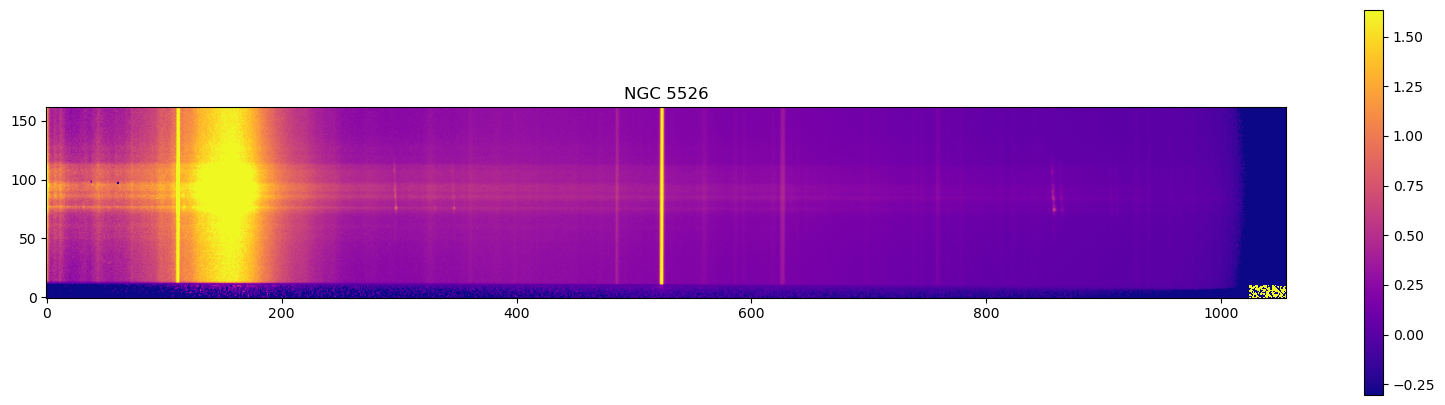

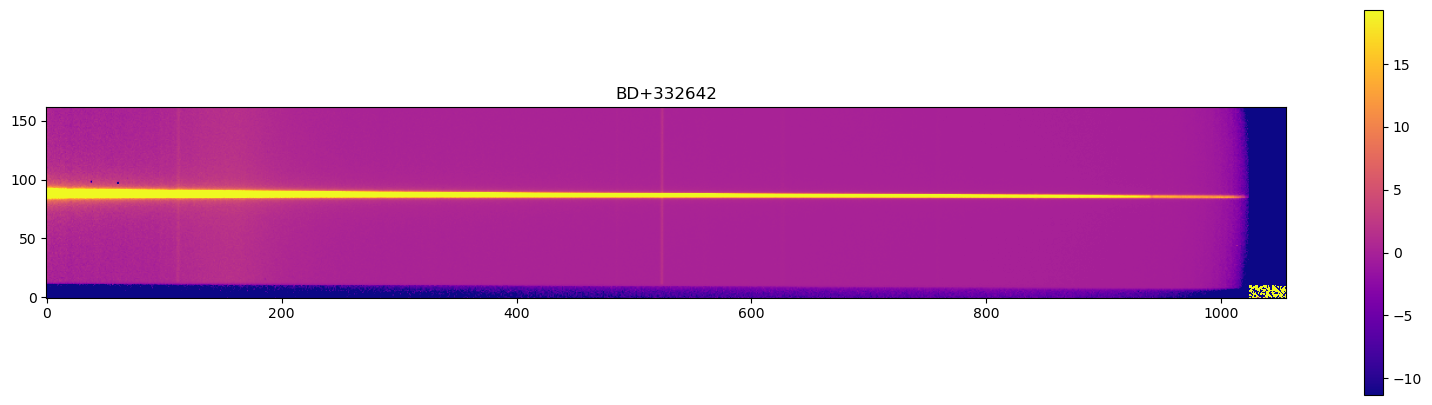

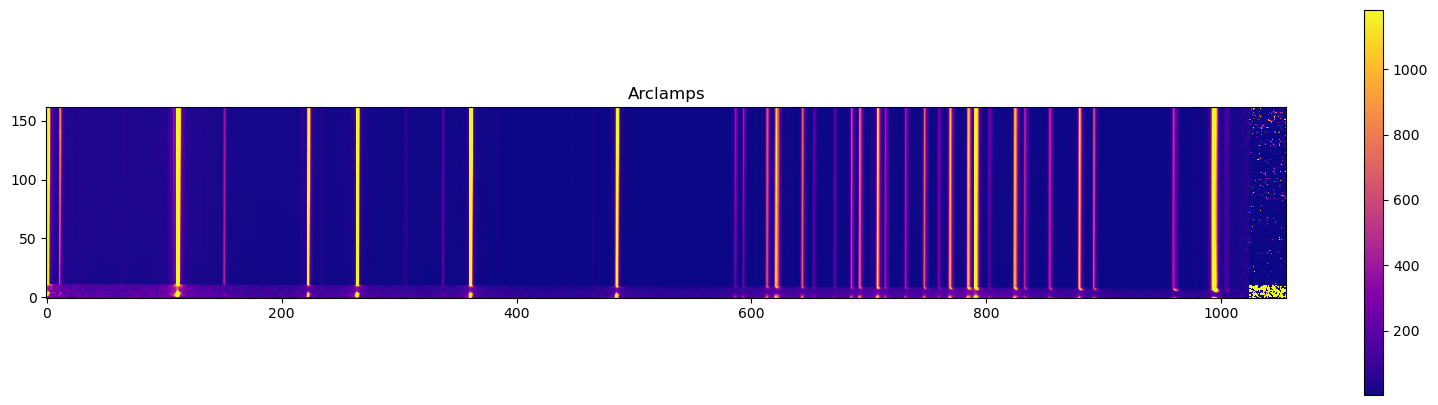

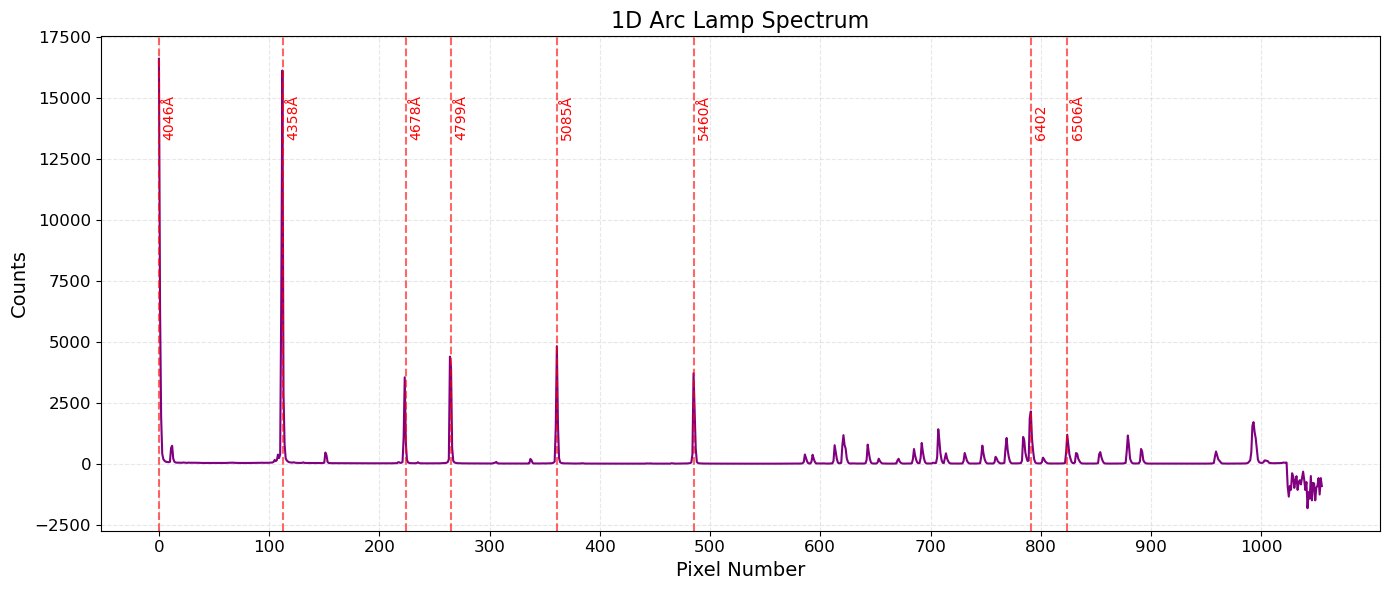

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


NGC_5526_stack = []
BD_stack = []
Arclamps_stack = []

for i in range(300):
    try:
        hdul = fits.open(f'c{i}.fits')
        header = hdul[0].header
        obj = header.get('OBJECT', '')
        exptime = header.get('EXPTIME', 1.0)
        cover = header.get('COVER', 0)

        if obj in ['NGC_5526', 'BD+332642', 'Arclamps']:
            data = hdul[0].data.astype('float64')
            if cover > 0:
                data = data[:, :-cover]
            data -= master_bias
            data /= exptime

            if obj == 'NGC_5526':
                NGC_5526_stack.append(data)
            elif obj == 'BD+332642':
                BD_stack.append(data)
            elif obj == 'Arclamps':
                Arclamps_stack.append(data)
        hdul.close()
    except FileNotFoundError:
        continue

if NGC_5526_stack:
    NGC_5526 = np.median(np.stack(NGC_5526_stack[:5]), axis=0)
    NGC_5526 = np.divide(NGC_5526, master_dome, where=master_dome != 0)
else:
    NGC_5526 = None
    print("No NGC_5526 frames found.")

if BD_stack:
    BD = np.median(np.stack(BD_stack), axis=0)
    BD = np.divide(BD, master_dome, where=master_dome != 0)
else:
    BD = None
    print("No BD+332642 frames found.")

if Arclamps_stack:
    Arc = np.median(np.stack(Arclamps_stack), axis=0)
    Arc = np.divide(Arc, master_dome, where=master_dome != 0)
else:
    Arc = None
    print("No Arc frames found.")

def plot_image(image, title):
    if image is None:
        print(f"{title} not available.")
        return

    plt.figure(figsize=(20,5))
    plt.imshow(image, cmap='plasma', origin='lower',
               vmin=np.percentile(image, 5),
    vmax=np.percentile(image, 98))
    plt.colorbar()
    plt.title(title)
    plt.savefig(f"{title}.png")
    plt.show()

plot_image(NGC_5526, "NGC 5526")
plot_image(BD, "BD+332642")
plot_image(Arc, "Arclamps")

if Arc is not None:
    arc_1d = np.median(Arc[100:110, :], axis=0)  
    pixels = np.arange(len(arc_1d))

    known_pixel_positions = [0, 224, 265, 361, 113, 485, 824, 791] 
    labels = ["4046Å", "4678Å", "4799Å", "5085Å", "4358Å", "5460Å", "6506Å", "6402"] 

    plt.figure(figsize=(14, 6))
    plt.plot(pixels, arc_1d, color='purple')
    plt.xlabel("Pixel Number", fontsize=14)
    plt.ylabel("Counts", fontsize=14)
    plt.title("1D Arc Lamp Spectrum", fontsize=16)
    plt.xticks(np.arange(0, len(pixels), 100), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)

    for x, label in zip(known_pixel_positions, labels):
        plt.axvline(x, color='red', linestyle='--', alpha=0.6)
        plt.text(x + 3, arc_1d.max() * 0.8, label, rotation=90,
                 color='red', fontsize=10, va='bottom')

    plt.tight_layout()
    plt.show()
    
# Spectrum of NGC 5526, spectrum of BD +332642, arclamp spectrum, labeled arclamp spectrum from visual analysis using known spectral lines

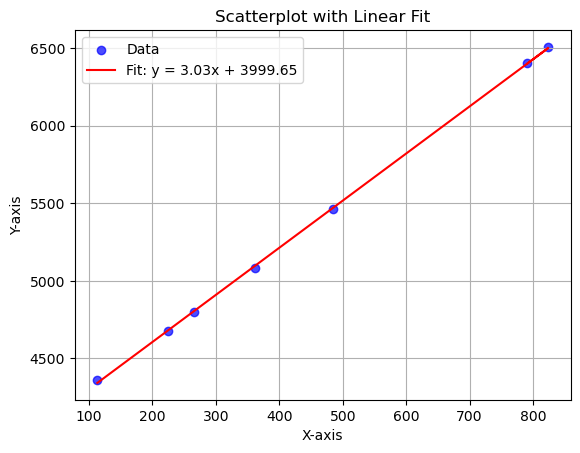

In [120]:
import numpy as np
import matplotlib.pyplot as plt

x = [113, 224, 265, 361, 485, 824, 791]
y = [4358, 4678, 4799, 5085, 5460, 6506, 6402]

coefficients = np.polyfit(x, y, 1)  
linear_fit = np.poly1d(coefficients)
plt.scatter(x, y, label='Data', color='blue', alpha=0.7)
plt.plot(x, linear_fit(x), label=f'Fit: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}', color='red')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatterplot with Linear Fit')
plt.legend()
plt.grid(True)
plt.show()
# fitting spectral lines and their pixel locations to get linear fit

In [121]:
median_profile = np.median(NGC_5526[:, 100:-100], axis=1)  

rows = np.arange(len(median_profile))


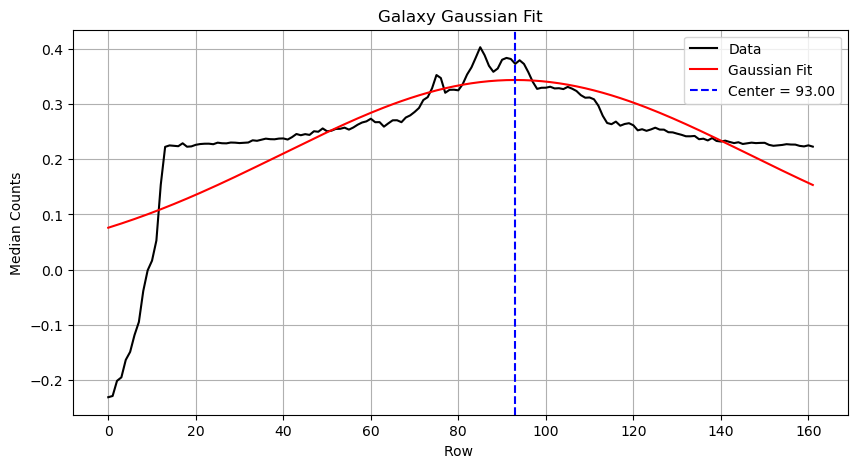

Estimated galaxy center (row): 93.00


In [134]:
from scipy.optimize import curve_fit

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) 

a_init = np.max(median_profile) - np.min(median_profile)
x0_init = np.argmax(median_profile)
sigma_init = 10


popt, _ = curve_fit(gaussian, rows, median_profile,
                    p0=[a_init, x0_init, sigma_init])

a_fit, x0_fit, sigma_fit = popt
galaxy_center = x0_fit

plt.figure(figsize=(10, 5))
plt.plot(rows, median_profile, label="Data", color='black')
plt.plot(rows, gaussian(rows, *popt), label="Gaussian Fit", color='red')
plt.axvline(galaxy_center, color='blue', linestyle='--', label=f'Center = {galaxy_center:.2f}')
plt.xlabel("Row ")
plt.ylabel("Median Counts")
plt.title("Galaxy Gaussian Fit")
plt.legend()
plt.grid(True)
plt.savefig("GAUSS.png")
plt.show()

print(f"Estimated galaxy center (row): {galaxy_center:.2f}")
#Using gaussian fit to find galactic center according to median counts

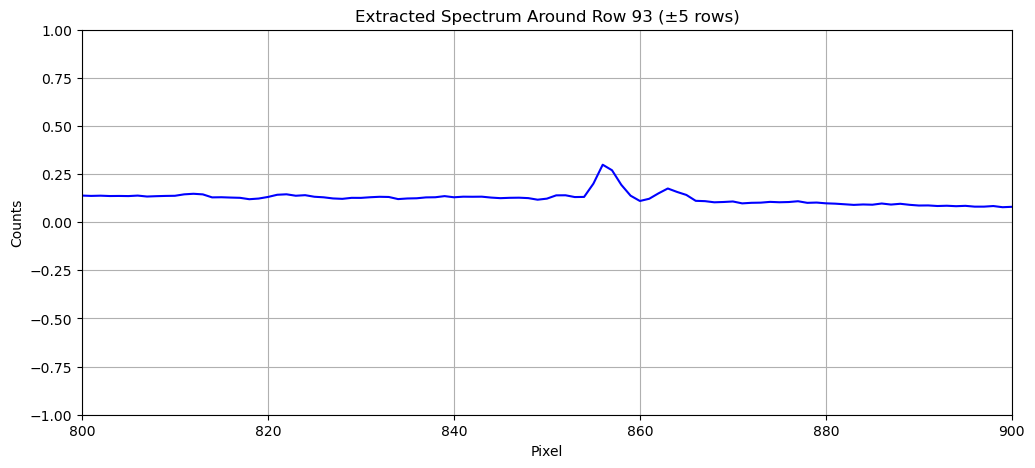

In [124]:
center_row = int(round(galaxy_center)) 

N = 5
spectrum_1d = np.median(NGC_5526[center_row - N:center_row + N + 1, :], axis=0)

pixels = np.arange(len(spectrum_1d))

plt.figure(figsize=(12, 5))
plt.plot(pixels, spectrum_1d, color='blue')
plt.xlabel("Pixel")
plt.ylabel("Counts")
plt.title(f"Extracted Spectrum Around Row {center_row} (±{N} rows)")
plt.grid(True)
plt.xlim(800, 900)
plt.ylim(-1,1)
plt.show()
#finding maximum counts around galactic center to find location of h alpha line

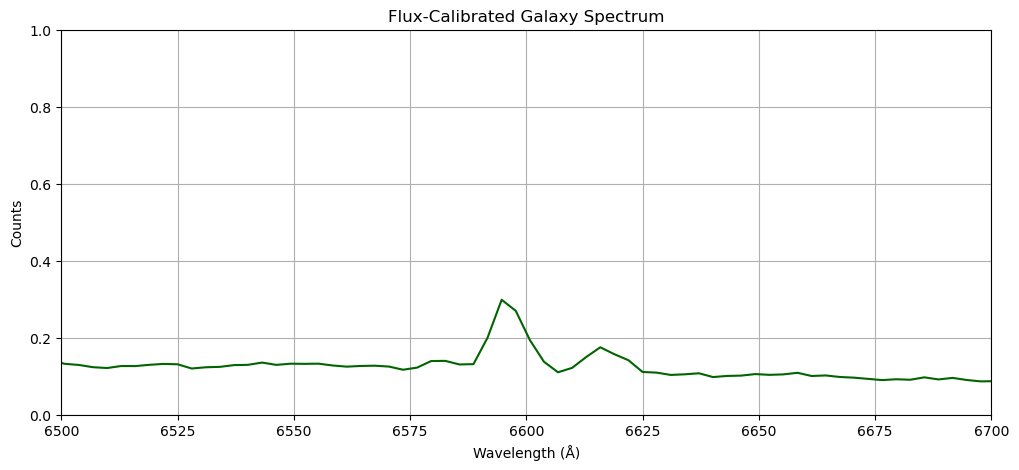

In [126]:
angstrom_per_pixel = 3.03
ref_pixel = 0
ref_wavelength = 4001 

wavelengths = ref_wavelength + angstrom_per_pixel * (pixels - ref_pixel)

plt.figure(figsize=(12, 5))
plt.plot(wavelengths, spectrum_1d, color='darkgreen')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Counts")
plt.title("Flux-Calibrated Galaxy Spectrum")
plt.grid(True)
plt.xlim(6500, 6700)
plt.ylim(0,1)
plt.show()
# using conversion to find maximum counts in terms of angstrom rather than pixels (using earlier linear fit)

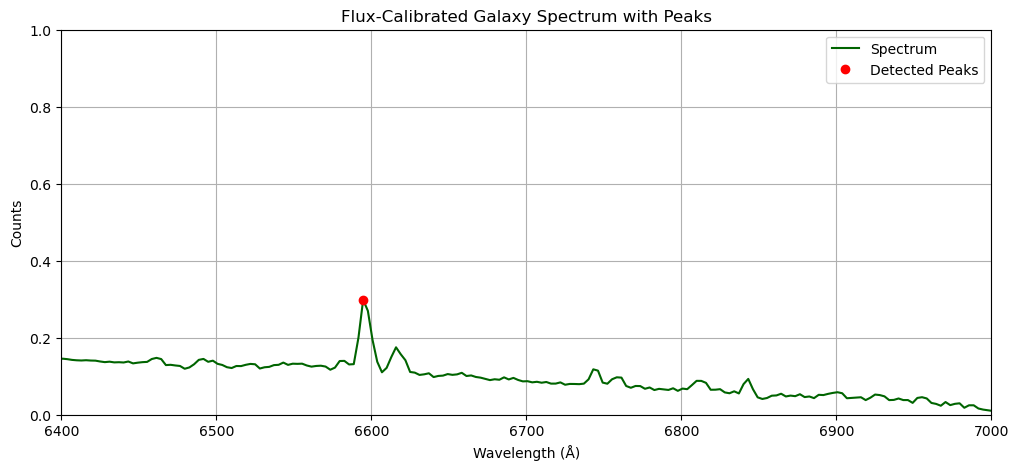

Detected Emission Peaks:
  λ = 4022.21 Å, Height = 1.18
  λ = 4037.36 Å, Height = 1.20
  λ = 4052.51 Å, Height = 1.00
  λ = 4058.57 Å, Height = 0.97
  λ = 4067.66 Å, Height = 0.93
  λ = 4076.75 Å, Height = 0.92
  λ = 4085.84 Å, Height = 0.85
  λ = 4091.90 Å, Height = 0.87
  λ = 4097.96 Å, Height = 0.90
  λ = 4110.08 Å, Height = 0.93
  λ = 4122.20 Å, Height = 0.96
  λ = 4131.29 Å, Height = 1.14
  λ = 4143.41 Å, Height = 1.03
  λ = 4158.56 Å, Height = 0.97
  λ = 4164.62 Å, Height = 0.96
  λ = 4179.77 Å, Height = 0.96
  λ = 4188.86 Å, Height = 0.99
  λ = 4204.01 Å, Height = 0.98
  λ = 4210.07 Å, Height = 1.03
  λ = 4222.19 Å, Height = 1.13
  λ = 4246.43 Å, Height = 1.14
  λ = 4258.55 Å, Height = 1.11
  λ = 4273.70 Å, Height = 1.15
  λ = 4291.88 Å, Height = 1.25
  λ = 4304.00 Å, Height = 1.24
  λ = 4328.24 Å, Height = 1.38
  λ = 4340.36 Å, Height = 2.33
  λ = 4352.48 Å, Height = 1.49
  λ = 4361.57 Å, Height = 1.48
  λ = 4373.69 Å, Height = 1.57
  λ = 4382.78 Å, Height = 1.63
  λ = 4391.87 

In [128]:
from scipy.signal import find_peaks

peaks, properties = find_peaks(spectrum_1d, height=0.2)

peak_wavelengths = wavelengths[peaks]
peak_heights = properties["peak_heights"]

plt.figure(figsize=(12, 5))
plt.plot(wavelengths, spectrum_1d, color='darkgreen', label="Spectrum")
plt.plot(peak_wavelengths, peak_heights, 'ro', label="Detected Peaks")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Counts")
plt.title("Flux-Calibrated Galaxy Spectrum with Peaks")
plt.xlim(6400, 7000)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

print("Detected Emission Peaks:")
for w, h in zip(peak_wavelengths, peak_heights):
    print(f"  λ = {w:.2f} Å, Height = {h:.2f}")

#finding peak counts, printing out associated wavelength for sanity check


In [129]:
lambda_rest = 6563.0  
lambda_obs = 6594
z = (lambda_obs - lambda_rest) / lambda_rest
z_err = lambda_err / lambda_rest

print(f"Hα observed at λ = {lambda_obs:.2f} ± {lambda_err:.2f} Å")
print(f"Redshift z = {z:.5f} ± {z_err:.5f}")
#Redshift calculation using observed h alpha line and literature value

Hα observed at λ = 6594.00 ± 0.12 Å
Redshift z = 0.00472 ± 0.00002


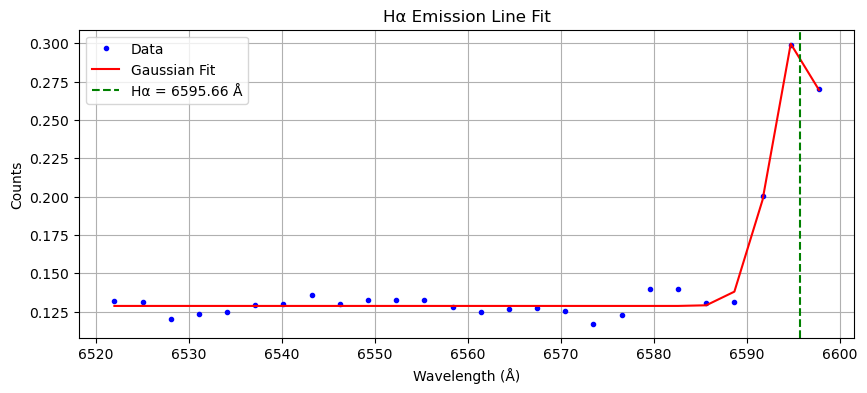

In [130]:

ha_region = (wavelengths > 6520) & (wavelengths < 6600)

x_data = wavelengths[ha_region]
y_data = spectrum_1d[ha_region]

a_guess = y_data.max() - y_data.min()
x0_guess = x_data[np.argmax(y_data)]
sigma_guess = 5 
offset_guess = np.median(y_data)

popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[a_guess, x0_guess, sigma_guess, offset_guess])

a, lambda_obs, sigma, offset = popt
lambda_err = np.sqrt(np.diag(pcov))[1] 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(x_data, y_data, 'b.', label='Data')
plt.plot(x_data, gaussian(x_data, *popt), 'r-', label='Gaussian Fit')
plt.axvline(lambda_obs, color='green', linestyle='--', label=f'Hα = {lambda_obs:.2f} Å')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Counts")
plt.title("Hα Emission Line Fit")
plt.legend()
plt.grid(True)
plt.show()
# using guassian fit to determinewavelength value of h alpha line

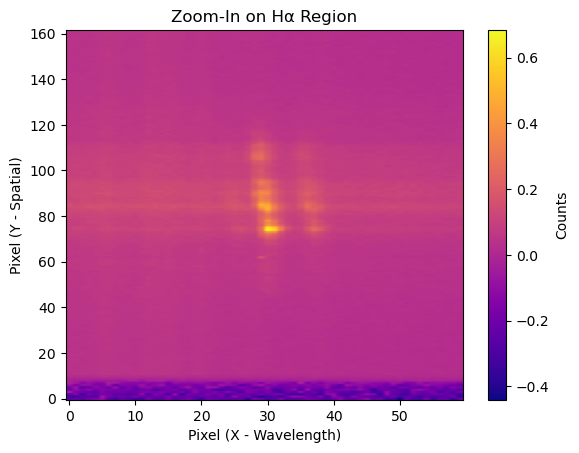

In [131]:
halpha_pixel = 857
window = 30
spectrum_cut = NGC_5526[:, halpha_pixel - window:halpha_pixel + window]

plt.imshow(spectrum_cut, origin='lower', cmap='plasma', aspect='auto')
plt.colorbar(label='Counts')
plt.title("Zoom-In on Hα Region")
plt.xlabel("Pixel (X - Wavelength)")
plt.ylabel("Pixel (Y - Spatial)")
plt.show()
#zoom in on h alpha region for visual analysis

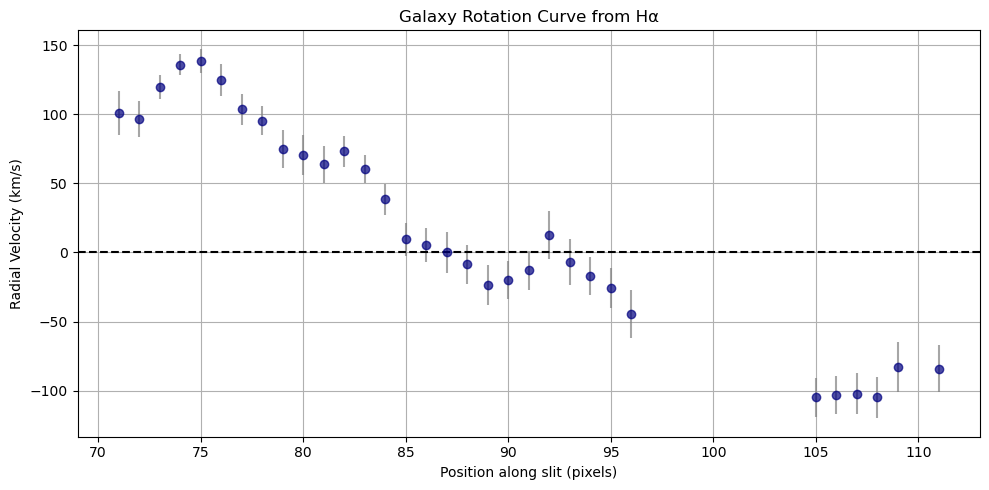

In [151]:
from scipy.optimize import curve_fit
import numpy as np

def gaussian(x, a, x0, sigma, offset):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset

y_size = spectrum_cut.shape[0]
x_pixels = np.arange(halpha_pixel - window, halpha_pixel + window)

centroids = []
errors = []
y_coords = []

for y in range(y_size):
    row = spectrum_cut[y, :]
    if np.max(row) < 0.2:
        continue

    try:
        p0 = [row.max() - np.median(row), np.argmax(row) + x_pixels[0], 3.0, np.median(row)]
        popt, pcov = curve_fit(gaussian, x_pixels, row, p0=p0)
        centroids.append(popt[1])  
        errors.append(np.sqrt(np.diag(pcov))[1])  
        y_coords.append(y)
    except:
        continue
ref_pixel = 856.5
ref_wavelength = 6594 
angstrom_per_pixel = 3.03

wavelengths = ref_wavelength + angstrom_per_pixel * (np.array(centroids) - ref_pixel)

c = 3e5 
velocities = c * (wavelengths - ref_wavelength) / ref_wavelength
velocity_errors = c * angstrom_per_pixel * np.array(errors) / ref_wavelength


plt.figure(figsize=(10, 5))  # line plot
plt.errorbar(y_coords, velocities, yerr=velocity_errors, fmt='o', color='navy', ecolor='gray', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Position along slit (pixels)")
plt.ylabel("Radial Velocity (km/s)")
plt.title("Galaxy Rotation Curve from Hα")
plt.grid(True)
plt.tight_layout()
plt.show()
#Creating galaxy rotation curve given previous analysis

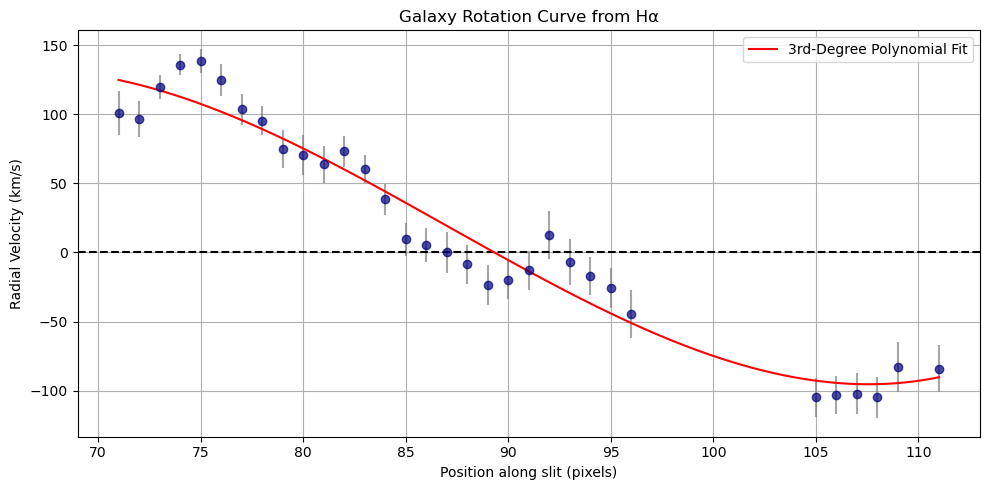

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, a, x0, sigma, offset):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset

def arctan_model(y, vmax, rt, offset):
    return vmax * (2 / np.pi) * np.arctan((np.array(y) - offset) / rt)

y_size = spectrum_cut.shape[0]
x_pixels = np.arange(halpha_pixel - window, halpha_pixel + window)

centroids = []
errors = []
y_coords = []

for y in range(y_size):
    row = spectrum_cut[y, :]
    if np.max(row) < 0.2:
        continue

    try:
        p0 = [row.max() - np.median(row), np.argmax(row) + x_pixels[0], 3.0, np.median(row)]
        popt, pcov = curve_fit(gaussian, x_pixels, row, p0=p0)
        centroids.append(popt[1])  # x0 is the centroid
        errors.append(np.sqrt(np.diag(pcov))[1])  # uncertainty in x0
        y_coords.append(y)
    except:
        continue

ref_pixel = 856.5
ref_wavelength = 6594  
angstrom_per_pixel = 3.03
c = 3e5  

centroids = np.array(centroids)
errors = np.array(errors)
y_coords = np.array(y_coords)

wavelengths = ref_wavelength + angstrom_per_pixel * (centroids - ref_pixel)
velocities = c * (wavelengths - ref_wavelength) / ref_wavelength
velocity_errors = c * angstrom_per_pixel * errors / ref_wavelength

plt.figure(figsize=(10, 5))
plt.errorbar(y_coords, velocities, yerr=velocity_errors, fmt='o', color='navy', ecolor='gray', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Position along slit (pixels)")
plt.ylabel("Radial Velocity (km/s)")
plt.title("Galaxy Rotation Curve from Hα")
plt.grid(True)

# ---- Option 1: Polynomial Fit (comment out if not needed) ----
poly_coeffs = np.polyfit(y_coords, velocities, deg=3)
poly_fit_func = np.poly1d(poly_coeffs)
y_fit = np.linspace(min(y_coords), max(y_coords), 300)
v_fit_poly = poly_fit_func(y_fit)
plt.plot(y_fit, v_fit_poly, color='red', label='3rd-Degree Polynomial Fit')



plt.legend()
plt.tight_layout()
plt.savefig("RotationCurve.png")
plt.show()
#fitting galaxy rotation curve using 3rd degree polynomial

In [157]:
import numpy as np

red_index = np.argmax(velocities)  
blue_index = np.argmin(velocities)  

red_index = np.argmax(velocities)
v_red = velocities[red_index]
err_red = velocity_errors[red_index]

blue_index = np.argmin(velocities)
v_blue = velocities[blue_index]
err_blue = velocity_errors[blue_index]

v_rot = (abs(v_red) + abs(v_blue)) / 2

err_rot = np.sqrt(err_red**2 + err_blue**2) / 2

print(f"Redshifted velocity = {v_red:.2f} ± {err_red:.2f} km/s")
print(f"Blueshifted velocity = {v_blue:.2f} ± {err_blue:.2f} km/s")
print(f"Estimated rotation velocity = {v_rot:.2f} ± {err_rot:.2f} km/s")
#using velocity rotation equation to find red and blueshifted velocities, as well as total estimated rotation velocity

Redshifted velocity = 138.81 ± 8.58 km/s
Blueshifted velocity = -104.95 ± 15.06 km/s
Estimated rotation velocity = 121.88 ± 8.67 km/s


Redshifted average = 105.68 ± 7.39 km/s
Blueshifted average = nan ± 0.00 km/s
Estimated rotation velocity = nan ± 3.69 km/s


C:\Users\Shast\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Shast\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


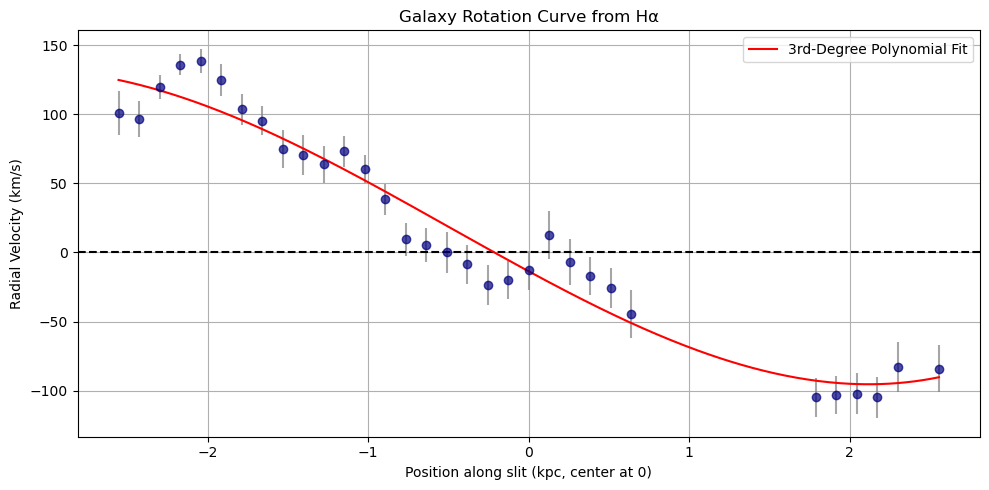

In [164]:
center_pixel = 91
y_shifted_pixels = y_coords - center_pixel
pixel_scale_arcsec = 0.8784
y_shifted_arcsec = y_shifted_pixels * pixel_scale_arcsec

D_Mpc = 30  # galaxy distance in Mpc
arcsec_to_rad = (1 / 3600) * (np.pi / 180)
y_shifted_kpc = D_Mpc * 1e6 * arcsec_to_rad * y_shifted_arcsec / 1000

# Polynomial fit with shifted kpc axis
poly_coeffs = np.polyfit(y_shifted_kpc, velocities, deg=3)
poly_fit_func = np.poly1d(poly_coeffs)
y_fit_kpc = np.linspace(min(y_shifted_kpc), max(y_shifted_kpc), 300)
v_fit_poly = poly_fit_func(y_fit_kpc)

# Plot with zero-centered x-axis
plt.figure(figsize=(10, 5))
plt.errorbar(y_shifted_kpc, velocities, yerr=velocity_errors, fmt='o', color='navy', ecolor='gray', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Position along slit (kpc, center at 0)")
plt.ylabel("Radial Velocity (km/s)")
plt.title("Galaxy Rotation Curve from Hα")
plt.grid(True)
plt.plot(y_fit_kpc, v_fit_poly, color='red', label='3rd-Degree Polynomial Fit')

plt.legend()
plt.tight_layout()
plt.savefig("RotationCurve_centered_kpc.png")
plt.show()
#changing x-axis to represent distance in kpc for better analysis of Vera Rubin theory

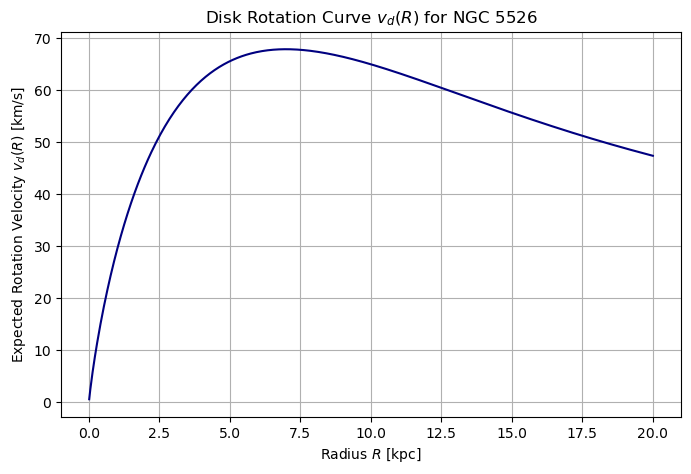

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv, kv  
from astropy.constants import G, M_sun
import astropy.units as u


Rd = 3.25 * u.kpc  
Md = 9e9 * M_sun   

Sigma_0 = Md / (2 * np.pi * Rd**2)

R_vals = np.linspace(0.01, 20, 500) * u.kpc
y = (R_vals / (2 * Rd)).decompose().value

term = y**2 * (iv(0, y) * kv(0, y) - iv(1, y) * kv(1, y))
vd_squared = (4 * np.pi * G * Sigma_0 * Rd * term).to(u.km**2 / u.s**2)

vd = np.sqrt(vd_squared)

# Plot rotation curve
plt.figure(figsize=(8, 5))
plt.plot(R_vals, vd, color='navy')
plt.title("Disk Rotation Curve $v_d(R)$ for NGC 5526")
plt.xlabel("Radius $R$ [kpc]")
plt.ylabel("Expected Rotation Velocity $v_d(R)$ [km/s]")
plt.grid(True)
plt.savefig("DiskRotExp.png")
plt.show()
#Finding disk rotation curve

In [104]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
halpha_pixel = 857  
ref_wavelength = 6594 
angstrom_per_pixel = 3.03
center_y = 93 
rows_per_slice = 5
max_offset = 40
window = 20
x_pixels = np.arange(halpha_pixel - window, halpha_pixel + window)

def gaussian(x, a, x0, sigma, offset):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset

pixel_shifts = []

for offset in range(-max_offset, max_offset + 1, rows_per_slice):
    y_start = center_y + offset
    y_end = y_start + rows_per_slice
    if y_start < 0 or y_end > NGC_5526.shape[0]:
        continue

    spectrum_slice = np.median(NGC_5526[y_start:y_end, halpha_pixel - window:halpha_pixel + window], axis=0)

    try:
        p0 = [spectrum_slice.max(), halpha_pixel, 3.0, np.median(spectrum_slice)]
        popt, pcov = curve_fit(gaussian, x_pixels, spectrum_slice, p0=p0)
        center_pix = popt[1]
        center_err = np.sqrt(np.diag(pcov))[1]
        pixel_shifts.append((offset, center_pix, center_err))
    except RuntimeError:
        continue
print("Offset (rows) | H-alpha Pixel Center ± Error")
for off, pix, err in pixel_shifts:
    print(f"{off:>6}         | {pix:.2f} ± {err:.2f}")

Offset (rows) | H-alpha Pixel Center ± Error
   -40         | 857.09 ± 0.27
   -35         | 856.78 ± 0.36
   -30         | 857.34 ± 0.37
   -25         | 857.33 ± 0.12
   -20         | 857.43 ± 0.08
   -15         | 857.06 ± 0.10
   -10         | 856.76 ± 0.09
    -5         | 856.37 ± 0.10
     0         | 856.43 ± 0.12
     5         | 855.88 ± 0.15
    10         | 855.75 ± 0.09
    15         | 855.87 ± 0.11
    20         | 855.75 ± 0.21
    25         | 855.43 ± 0.49
    30         | 872.29 ± 4.03
    35         | 881.69 ± 15.48
    40         | 877.69 ± 12.01


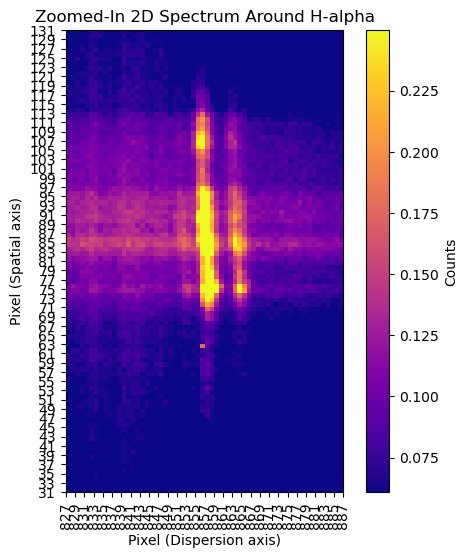

In [113]:
import matplotlib.pyplot as plt
import numpy as np

x_center = 857
x_width = 30
x_min = x_center - x_width
x_max = x_center + x_width

y_center = NGC_5526.shape[0] // 2
y_width = 50
y_min = y_center - y_width
y_max = y_center + y_width

zoomed = NGC_5526[y_min:y_max, x_min:x_max]

extent = [x_min, x_max, y_min, y_max]

plt.figure(figsize=(6, 6))
plt.imshow(zoomed, origin='lower', cmap='plasma', aspect='equal',
           extent=extent,
           vmin=np.percentile(zoomed, 40),
           vmax=np.percentile(zoomed, 99))
plt.colorbar(label="Counts")
plt.title("Zoomed-In 2D Spectrum Around H-alpha")
plt.xlabel("Pixel (Dispersion axis)")
plt.ylabel("Pixel (Spatial axis)")
plt.xticks(np.arange(x_min, x_max + 1, 2),rotation=90)
plt.yticks(np.arange(y_min, y_max + 1, 2))
plt.grid(False)
plt.show()
#extremely zoomed in h alpha area with more specific labels for analysis